# Control Variate Technique for Binomial Tree Prices

### Motivation
This illustrates the use of the Control Variate technique for reducing the variance of an estimate for an option price calculated on a Binomial tree. See  https://en.wikipedia.org/wiki/Control_variates or Simulation by S.M. Ross. The application to pricing American Put options using the corresponding European option is discussed by 
Hull \& White in 'The Use of the Control Variate Technique in Option Pricing', J. of Finance, 42 (June 1987), 281-300; THE CONVERGENCE OF BINOMIAL TREES FOR PRICING
THE AMERICAN PUT M.Joshi 2008; and
[On the use and improvement of Hull and White’s control variate technique](https://scholars.lib.ntu.edu.tw/bitstream/123456789/165629/1/22.pdf)



Here we price an American option by using the corresponding European option which has an analytic expression for it's price given by the Black-Scholes formula. We first estimate the optimal coefficient, $c^*$ in the expression
$$Z\equiv X + c(Y - \mu_Y)$$ so as to minimize it's variance: 
$$Var[Z] = Var[X] + c^2Var[Y] +2cCov[X,Y]$$
$$c^* = -Cov(X,Y) / Var(Y).$$ We then have $$E[Z] = E[X]$$ $$Var[Z] = Var[X] -(Cov[X,Y])^2 / Var[Y]$$ 
or:
$${Var[Z]\over Var[X]} = (1 - Corr^2[X, Y])$$
By choosing X, Y as the price of the American, European option calculated on the binomial tree, and setting $\mu_Y$ as the Black-Scholes price of the European option, $Z$ calculated from the binomial tree will estimate the price of the American option with reduced variance. 

Strictly speaking, this technique applies to sampling from a fixed distribution of random numbers. We estimate $c^*$ from sample estimates of $Cov[X, Y]$ and $Var[Y]$ where $X, Y$ are sample realizations drawn from that distribution. As applied in the above mentioned references, and here, $X, Y$ are American and European option prices obtained from Binomial trees. A Binomial tree of a given number of timesteps, `N_steps`, produces a  single, completely deterministic price. One can easily imagine using the technique on option prices produced by a (fixed) Monte Carlo engine where each realized price is a random number drawn from the distribution produced by that MC engine (number of timesteps, $r, \sigma, T,...$ all fixed). Estimating c* from the first several realizations of (X, Y), then allows to construct $Z$ with the above properties on subsequent simulations from that same MC engine.

What is the distribution we are drawing $X, Y$ from when the are option prices produced by Binomial trees? Following the previous authors, we let the number of time steps, `N_steps`[<sup id="fn1-back">1</sup>](#fn1), used in the construction of the binomial tree play the role of randomness, i.e., we estimate $c^*$, $Cov[X,Y], Var[Y]$ from a 'sample' of trees having some range of `N_steps`. We imagine that by observing how $X, Y$ covary, we can form the above $Z$, which will then have the same mean and smaller variance over our selected `N_steps` grid. We take the further step of estimating $Cov[X,Y], Var[Y]$ and $c^*$, on a range of smaller trees(to obtain $c^*_{small}$), then calculate $Z$ on large tree(s). Even if the true $c^*$ varies with tree size, $E[Z] = E[X]$ is always true, and hopefully we get reduced variance on the larger trees using $c^*_{small}$ instead of the computationally more expensive $c^*_{large}$. Let's see how well this works.







[<sup id="fn1">1</sup>](#fn1-back) only `N_steps` varies, all other parameters($S_o, r, T, K, \sigma, ...$) of the tree and option are fixed.




In [1]:
#include "option_pricing.hpp"
#include "option_pricing.cc"

### An Implementation
Borrowing from ML terminology we will calculate the optimal $c^*$ on the *training* set of binomial trees having `N_steps` time steps on [20, 100], and then we will use this $c^*$ to estimate the price of the American option on a large tree having `N_steps` near 1000-10000. We will first confirm that this choice of $c^*$ leads to reduced variance in line with the above formula.

We calculate the sample variances for each of: the American option prices, the American option prices using control variate with $c=1$, the American option prices using the optimal control variate ($c^*$). We check the $c=1$ case just because Hull-White, and M. Joshi each use $c=1$ and to confirm this choice is not optimal. Looking at the This confirms that use of $c^*$ reduces variance by the factor $(1 - Corr^2[X, Y]) = 1 - 0.990989^2=0.01794$.

Repeating the same calculations for a `test` set of binomial trees having `N_steps` on [1000, 1080] confirms that the $c^*$ obtained from the training set does a good job reducing the variance. Of course $c^*_large$ obtained from the test set does a better job (and that should therefore be used if you are generating enough large trees to give a good estimate of $c^*$. )

Note: The variance  is small enough to see a trend: the estimated American option prices decrease from 1.99065 to 1.99055 as `N_steps` increases from 1000 to 4000. Increasing `N_steps` by 1 near `N_steps`=4000 shows the familiar up/down price dependence. The up/down price envelope of the covariate corrected prices is decreasing, the (larger) up/down price envelope of the raw prices is increasing. Exrapolating these, or fitting some curve to them, may give a better option price estimate.

The upshot of all this, barring completion of the mentioned study to fit extrapolating curves, is that a European option as control variate with $c^* = c^*_{small}$ gives low variance price estimates for the corresponding American. But one should sample prices from a few binomial trees having larger `N_steps` to see if there is a trend detectable given this low noise observational tool.

In [2]:
// control_var.cc:
#include <iomanip>

using namespace OptionPricing;

using std::cout;
using std::endl;
using std::valarray;

// Construct the Amer and Euro Put options for a particular parameter set:
double S_o = 40.0, r = 0.0488, q = 0.0;
double K = 40.0, T = 7 / 12., sigma = 0.2;
Asset underlying{ S_o, q, sigma };
Terms terms_amer_put{ Terms::Style::Amer, Terms::Type::Put, T, K };
Terms terms_euro_put{ Terms::Style::Euro, Terms::Type::Put, T, K };
Option amer_put(terms_amer_put, underlying);
Option euro_put(terms_euro_put, underlying);

// Get their prices on the training set of binomial trees having N_steps on [20, 100] into
// the arrays amer_prcs, euro_prcs:
bool get_greeks = false;
constexpr int start_N = 20, end_N = 100;
constexpr int N_points{ end_N - start_N + 1 }; // Number of training points.

valarray<double> amer_prcs(N_points);
valarray<double> euro_prcs(N_points);


for (int N_steps = start_N; N_steps < end_N + 1; ++N_steps) {
    amer_prcs[N_steps - start_N] = amer_put.btree_prc(N_steps, r, get_greeks);
    euro_prcs[N_steps - start_N] = euro_put.btree_prc(N_steps, r, get_greeks);
}

// Calculate their sample means, vars and covariance:
double amer_mean = amer_prcs.sum() / N_points;
double euro_mean = euro_prcs.sum() / N_points;

double var_amer = ((amer_prcs - amer_mean) * (amer_prcs - amer_mean)).sum() / (N_points - 1);
double var_euro = ((euro_prcs - euro_mean) * (euro_prcs - euro_mean)).sum() / (N_points - 1);
double cov_a_e = ((amer_prcs - amer_mean) * (euro_prcs - euro_mean)).sum() / (N_points - 1);


// Get the theoretical optimum coefficient, c (for this parameter set):
double c = cov_a_e / var_euro;
cout << "Training Set (binomial trees having N_steps on [" << start_N << " : "
<< end_N << "]) Results:" << endl;
cout << "Optimal c: " << c << endl;
cout << "Corr(Amer, Euro): " << cov_a_e / (sqrt(var_amer) * sqrt(var_euro)) << endl;

// Get the Black-Scholes Euro option price:
double d_1 = (std::log(S_o / K) + (r - q + sigma * sigma / 2) * T) / (sigma * std::sqrt(T));
double d_2 = d_1 - sigma * std::sqrt(T);
double BS_prc = std::exp(-r * T) * K * std::erfc(d_2 / std::sqrt(2)) / 2
- S_o * std::erfc(d_1 / std::sqrt(2)) / 2;

// Get the variance of Amer option prices via the optimal, and the Hull, White (c==1) control
// variate admixture:
valarray<double> amer_prcs_HW = amer_prcs - (euro_prcs - BS_prc);
valarray<double> amer_prcs_opt = amer_prcs - c * (euro_prcs - BS_prc);
double amer_mean_HW = amer_prcs_HW.sum() / N_points;
double amer_mean_opt = amer_prcs_opt.sum() / N_points;
double var_amer_HW = ((amer_prcs_HW - amer_mean_HW) * (amer_prcs_HW - amer_mean_HW)).sum() / (N_points - 1);
double var_amer_opt = ((amer_prcs_opt - amer_mean_opt) * (amer_prcs_opt - amer_mean_opt)).sum() / (N_points - 1);
cout << "Var and stddev of Z = A -c(E - BS_prc):" << endl;
cout << "         c                  Var | stddev" << endl;
cout << "None, c=0            " << var_amer << '|' << sqrt(var_amer) << endl;
cout << "Hull-White, c=1      " << var_amer_HW << '|' << sqrt(var_amer_HW) << endl;
cout << "Optimal c=Cov/Var    " << var_amer_opt << '|' << sqrt(var_amer_opt) << endl;
cout << "Mean of raw American prices: " << std::setprecision(10) << amer_mean << endl;
cout << "Mean of Hull-White prices:   " << std::setprecision(10) << amer_mean_HW << endl;
cout << "Mean of opt c* prices:       " << std::setprecision(10) << amer_mean_opt << endl;
cout << "Mean of raw European prices: " << std::setprecision(10) << euro_mean << endl;
cout << "Black-Scholes European price: " << std::setprecision(10)<< BS_prc << endl;


// Out of sample test on binomial trees same number, N_points, of points as training sample
// but all trees having N_steps >> end_N.
// Test grid: [4000 : 4000 + N_points]
int test_start_N = 4000;
int test_end_N = 4000 + N_points - 1;
cout << "\nTest set (binomial trees having N_steps on [" << test_start_N << " : "
<< test_end_N << "]) Results:" << endl;

for (int N_steps = test_start_N; N_steps < test_end_N + 1; ++N_steps) {
    amer_prcs[N_steps - test_start_N] = amer_put.btree_prc(N_steps, r, get_greeks);
    euro_prcs[N_steps - test_start_N] = euro_put.btree_prc(N_steps, r, get_greeks);
}

// Calculate their sample means, vars and covariance:
amer_mean = amer_prcs.sum() / N_points;
euro_mean = euro_prcs.sum() / N_points;

var_amer = ((amer_prcs - amer_mean) * (amer_prcs - amer_mean)).sum() / (N_points - 1);
var_euro = ((euro_prcs - euro_mean) * (euro_prcs - euro_mean)).sum() / (N_points - 1);
cov_a_e = ((amer_prcs - amer_mean) * (euro_prcs - euro_mean)).sum() / (N_points - 1);
// Get the theoretical optimum mix of the Euro option control variate (for this parameter set):
double c_testset = cov_a_e / var_euro;
cout << "Optimal c (in test set): " << c_testset << endl;
cout << "Test set Corr(Amer, Euro): " << cov_a_e / (sqrt(var_amer) * sqrt(var_euro)) << endl;

// Get the variance of Amer option prices via the optimal, and the Hull, White (c==1) control
// variate admixture:
amer_prcs_HW = amer_prcs - (euro_prcs - BS_prc);
amer_prcs_opt = amer_prcs - c * (euro_prcs - BS_prc); // Use c from training set!
amer_mean_HW = amer_prcs_HW.sum() / N_points;
amer_mean_opt = amer_prcs_opt.sum() / N_points;
var_amer_HW = ((amer_prcs_HW - amer_mean_HW) * (amer_prcs_HW - amer_mean_HW)).sum() / (N_points - 1);
var_amer_opt = ((amer_prcs_opt - amer_mean_opt) * (amer_prcs_opt - amer_mean_opt)).sum() / (N_points - 1);



cout << "Var and stddev of Z = A -c(E - BS_prc):" << endl;
cout << "         c                  Var | stddev" << endl;
cout << "None, c=0            " << var_amer << '|' << sqrt(var_amer) << endl;
cout << "Hull-White, c=1      " << var_amer_HW << '|' << sqrt(var_amer_HW) << endl;
cout << "Optimal c=Cov/Var    " << var_amer_opt << '|' << sqrt(var_amer_opt) << endl;
cout << "Mean of raw American prices: " << std::setprecision(10) << amer_mean << endl;
cout << "Mean of Hull-White prices:   " << std::setprecision(10) << amer_mean_HW << endl;
cout << "Mean of opt c* prices:       " << std::setprecision(10) << amer_mean_opt << endl;
cout << "Mean of raw European prices: " << std::setprecision(10) << euro_mean << endl;


Training Set (binomial trees having N_steps on [20 : 100]) Results:
Optimal c: 0.669685
Corr(Amer, Euro): 0.990989
Var and stddev of Z = A -c(E - BS_prc):
         c                  Var | stddev
None, c=0            8.17512e-05|0.00904164
Hull-White, c=1      2.09987e-05|0.00458243
Optimal c=Cov/Var    1.46672e-06|0.00121108
Mean of raw American prices: 1.992744836
Mean of Hull-White prices:   1.993368068
Mean of opt c* prices:       1.993162205
Mean of raw European prices: 1.880596634
Black-Scholes European price: 1.881219865

Test set (binomial trees having N_steps on [4000 : 4080]) Results:
Optimal c (in test set): 0.6767021003
Test set Corr(Amer, Euro): 0.9999976253
Var and stddev of Z = A -c(E - BS_prc):
         c                  Var | stddev
None, c=0            9.845159608e-09|9.922277767e-05
Hull-White, c=1      2.247193411e-09|4.740457162e-05
Optimal c=Cov/Var    1.105301891e-12|1.051333387e-06
Mean of raw American prices: 1.990541601
Mean of Hull-White prices:   1.99054874

In [4]:
// Write Amer, Euro and Opt(Z with c=c_training) prices vs N_steps:
#include <fstream>
using std::endl;

std::fstream outfile("prcs_4000-4080.csv", std::ios_base::out);
for (int N_steps = test_start_N; N_steps < test_end_N + 1; ++N_steps) {
    outfile << N_steps << "," << amer_prcs[N_steps - test_start_N] << ',' 
            << euro_prcs[N_steps - test_start_N] << ',' 
            << std::setprecision(10) << amer_prcs_opt[N_steps - test_start_N] << endl;
}
outfile.close();

// write Amer, Euro and Optimal price envelopes for N_steps on [1000, 20000]:
outfile.open("prcs_1000-20000.csv", std::ios_base::out);
for (int N_steps = 1000; N_steps < 20002; ++N_steps) {
    if (N_steps % 1000 < 2) {   // Get the high/low price pair at every 1000th.
        double a = amer_put.btree_prc(N_steps, r, get_greeks);
        double e = euro_put.btree_prc(N_steps, r, get_greeks);
        outfile << N_steps << "," << a << ',' << e << ',' << a - c * (e - BS_prc) << endl;
    }
}


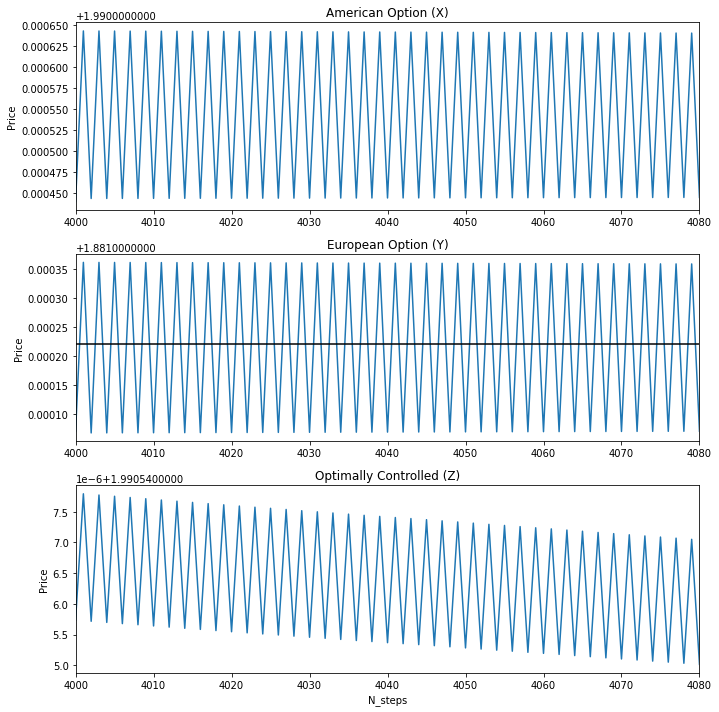

In [61]:
# Plot American, European and Z(min variance) prices for N_steps on [4000, 4080]:
import numpy as np
import matplotlib.pyplot as plt

N_steps, a, e, opt = np.loadtxt("prcs_4000-4080.csv", delimiter=',', unpack=True)


fig, ax = plt.subplots(3, 1, figsize=(10,10))
ax[0].plot(N_steps, a)
ax[0].set_title("American Option (X)")
ax[0].set_xlim(N_steps[0], N_steps[-1])
ax[0].set_ylabel('Price')

ax[1].plot(N_steps, e)
ax[1].set_title("European Option (Y)")
ax[1].axhline(y=1.88122, color="black")
ax[1].set_xlim(N_steps[0], N_steps[-1])
ax[1].set_ylabel('Price')

ax[2].plot(N_steps, opt)
ax[2].set_title("Optimally Controlled (Z)")
ax[2].set_xlim(N_steps[0], N_steps[-1])
ax[2].set_xlabel('N_steps')
ax[2].set_ylabel('Price')
fig.tight_layout()
plt.show()


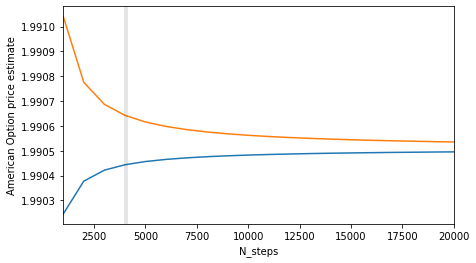

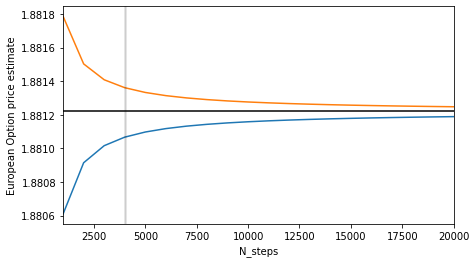

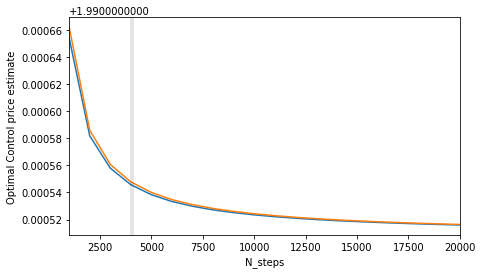

In [47]:
# American, European and Z(min variance) prices for N_steps on [1000, 20000]:
N_steps, a, e, opt = np.loadtxt("prcs_1000-20000.csv", delimiter=',', unpack=True)
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(N_steps[::2], a[::2], N_steps[1::2], a[1::2])
ax.axvline(x=4000, linewidth = .2, color='black')
ax.axvline(x=4080, linewidth = .2, color='black')
ax.set_xlim(N_steps[0], N_steps[-1])
ax.set_xlabel('N_steps')
ax.set_ylabel('American Option price estimate')
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(N_steps[::2], e[::2], N_steps[1::2], e[1::2])
ax.axvline(x=4000, linewidth = .2, color='black')
ax.axvline(x=4080, linewidth = .2, color='black')
ax.axhline(y=1.88122, color='Black')
ax.set_xlim(N_steps[0], N_steps[-1])
ax.set_xlabel('N_steps')
ax.set_ylabel('European Option price estimate')
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(N_steps[::2], opt[::2], N_steps[1::2], opt[1::2])
ax.axvline(x=4000, linewidth = .2, color='black')
ax.axvline(x=4080, linewidth = .2, color='black')
ax.set_xlim(N_steps[0], N_steps[-1])
ax.set_xlabel('N_steps')
ax.set_ylabel('Optimal Control price estimate')
plt.show()